In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
from nets import txtbox_300
from skimage.transform import resize

In [4]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization
# another v

In [5]:
isess = tf.InteractiveSession()

In [ ]:
import tensorflow as tf
sess = tf.Session()
tf.contrib.framework.list_variables('../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt')


In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.

image_pre, labels_pre, bboxes_pre, bbox_img, num = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
#anchors = net.anchors(net_shape)
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=None,use_batch=True)
    #localisations, predictions = net.bboxes_encode(bboxes_pre, anchors, 3,match_threshold = 0.5)
    for i in range(len(predictions)):
        predictions[i] = tf.nn.softmax(predictions[i])
        


{'global': <tf.Tensor 'text_box_300/global/conv3x3/Relu:0' shape=(1, 1, 1, 256) dtype=float32>, 'conv3': <tf.Tensor 'text_box_300/conv3/conv3_3/Relu:0' shape=(1, 75, 75, 256) dtype=float32>, 'conv2': <tf.Tensor 'text_box_300/conv2/conv2_2/Relu:0' shape=(1, 150, 150, 128) dtype=float32>, 'conv1': <tf.Tensor 'text_box_300/conv1/conv1_2/Relu:0' shape=(1, 300, 300, 64) dtype=float32>, 'conv10': <tf.Tensor 'text_box_300/conv10/conv3x3/Relu:0' shape=(1, 3, 3, 256) dtype=float32>, 'conv7': <tf.Tensor 'text_box_300/conv7/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv6': <tf.Tensor 'text_box_300/conv6/Relu:0' shape=(1, 19, 19, 1024) dtype=float32>, 'conv5': <tf.Tensor 'text_box_300/conv5/conv5_3/Relu:0' shape=(1, 19, 19, 512) dtype=float32>, 'conv4': <tf.Tensor 'text_box_300/conv4/conv4_3/Relu:0' shape=(1, 38, 38, 512) dtype=float32>, 'conv9': <tf.Tensor 'text_box_300/conv9/conv3x3/Relu:0' shape=(1, 5, 5, 256) dtype=float32>, 'conv8': <tf.Tensor 'text_box_300/conv8/conv3x3/Relu:0' shape=

In [7]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/logs/model.ckpt-3000')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/logs/model.ckpt-3000


In [8]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d,predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    #rbboxes,rclasses, rscores = np_methods.non_max_suppression_fast(rclasses, rscores,rbboxes, nms_threshold)
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes,rimg

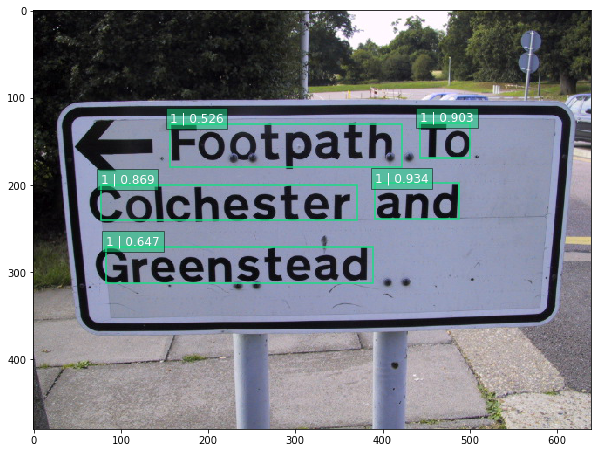

In [32]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Training-Images/100.jpg')
#img = resize(img, [700,700],mode='wrap',preserve_range=True)
rclasses, rscores, rbboxes,rimg =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [9]:
import glob
images = glob.glob('../data/ICDAR2013/ICDAR-Test-Images/*')
images[0]
def plt_bboxes(img, classes, scores, bboxes, figsize=(10,10), linewidth=1.5, savename=None):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!
    """
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(classes.shape[0]):
        cls_id = int(classes[i])
        if cls_id >= 0:
            score = scores[i]
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            ymin = int(bboxes[i, 0] * height)
            xmin = int(bboxes[i, 1] * width)
            ymax = int(bboxes[i, 2] * height)
            xmax = int(bboxes[i, 3] * width)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=linewidth)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            plt.gca().text(xmin, ymin - 2,
                           '{:s} | {:.3f}'.format(class_name, score),
                           bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                           fontsize=12, color='white')
    savepath = '../data/result/'
    plt.savefig(savename)
    plt.close()
    #plt.show()

In [10]:
for i in images:
    img = mpimg.imread(i)
    rclasses, rscores, rbboxes,rimg =  process_image(img)
    plt_bboxes(img, rclasses, rscores, rbboxes, savename='../data/result/'+i.split('/')[-1])

In [ ]:
rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d,predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
#rpredictions

In [ ]:
for i in range(6):
    print rlocalisations[i][np.where(rpredictions[i][:,:,:,:,:,1:] > 0.99)].shape

In [ ]:
rimg.shape

In [ ]:
#rpredictions.shape
loss = isess.run(tf.nn.softmax(tf.constant([[0.52,0.47],[-0.52,-0.47]])))
logit_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = tf.constant([[0.52,0.47],[-0.52,-0.47]]),
                                                         labels =tf.constant([0,1]) )
print isess.run([logit_loss])
print loss
print isess.run(tf.reduce_mean(logit_loss))

In [ ]:
l1 = tf.losses.compute_weighted_loss(logit_loss, tf.constant([1.0,0.]))
isess.run([l1])

In [ ]:
l_loss = tf.reduce_sum(logit_loss *  tf.constant([[1.0],[0.]])/1.0)
isess.run([l_loss])
logit_loss *  tf.constant([1.0,0.])